## Time Series Forecasting in Python

We would use the drug Sales Data that available to the public

In [1]:
#Import the usual library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

## Open the data with datetime object as the index

For our practice, we would use drug sales dataset which only have 2 variable; the date and the sales average for each day. 

We would work on the time series data, for that we need to set the index as the datetime object. Lets set the date as the index, and transform this feature as datetime object.

In [2]:
drugdf = pd.read_csv('drug_sales.csv', parse_dates = ['date'], index_col = 'date')

In [3]:
drugdf.head()

,sales_value_average
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


We could check our data time range by using the .min and .max properties

In [4]:
print('The data Time range from {} to {}'.format(drugdf.index.min(),drugdf.index.max()))

The data Time range from 1991-07-01 00:00:00 to 2008-06-01 00:00:00


From the time range, we could see that our data is spanning from 1 July 1991 until 1 June 2008

## Data Preprocessing

Before we input our data to the forecasting model, we need to preprocessing the data that is ready to be input into the model. 

Lets assume that we want to predict how our drug sales would be in the future for each month. In this case we could transform the data into monthly average sales data instead of daily data. 

In this case we could use the .resample method by pandas. Resample method need the data index as a datetime object and would convert the time series data to a particular frequency; the data return as resample object. Resample accept frequency string parameter to decide which frequency we want to use. 
Please refer to this link https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects to see all the available frequeny string.

In our case, we would use 'MS' frequency string as the data we want is the monthly data. 'MS' would refer to the Calendar Month Begin, which mean our data would be calculated from the start of the calendar month until the end of the month.

As .resample method only return the resample object;not the series itself, we need to call another method to acquired of our expected data. Lets use .mean to get our sales average for each month. 

In [5]:
y = drugdf['sales_value_average'].resample('MS').mean()

In [6]:
y.head()

date
1991-07-01    3.526591
1991-08-01    3.180891
1991-09-01    3.252221
1991-10-01    3.611003
1991-11-01    3.565869
Freq: MS, Name: sales_value_average, dtype: float64

In [7]:
y.isna().any()

False

## Data Visualization and Analysis

Lets visualize the data to get better insight of the data

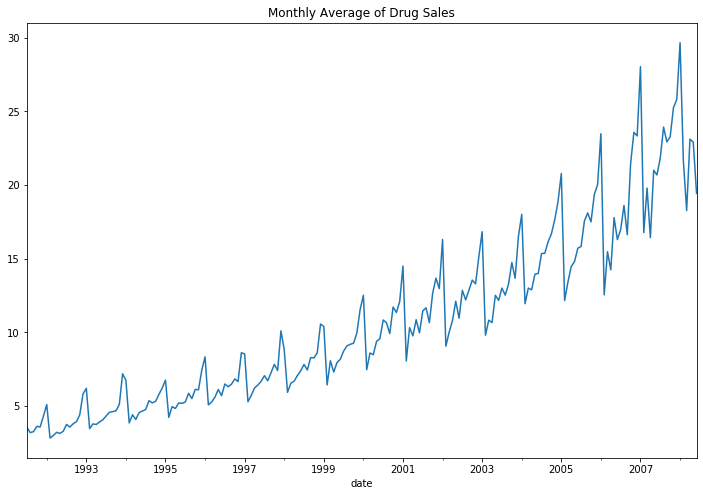

In [8]:
plt.figure(figsize = (12,8))
plt.title('Monthly Average of Drug Sales')
y.plot()

It is clear that our sales data is increasing as the time goes, and we could assume that this data is increasing exponentially because of what the plot shown to us.

The building block of the time series data are Seasonality, Cyclic and Trend. Not all series have all this pattern, but if they are present it could help us understand our data behaviour. Check this link http://itfeature.com/time-series-analysis-and-forecasting/component-of-time-series-data to understand the concept even more. 

Lets 'decompose' our time series data. Decompose is a process to separate our data observation to acquired the Trend+Cyclic pattern, Seasonality pattern, and the residual

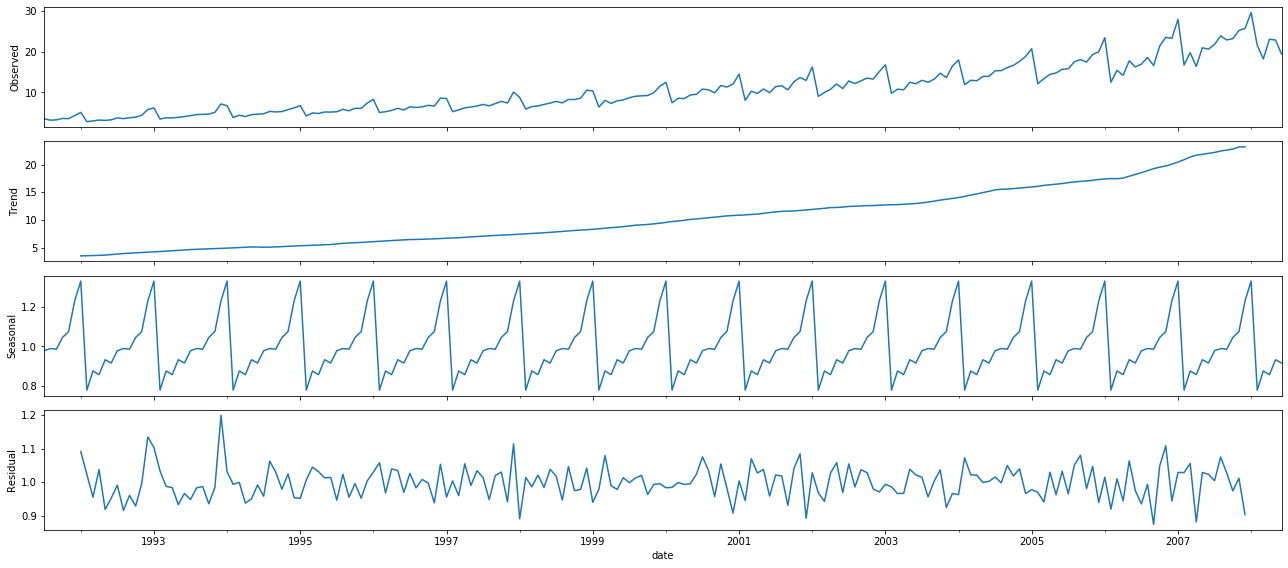

In [9]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multipicative')
fig = decomposition.plot()
plt.show()

Formally if Y is the number of the drug sold during certain time, we can calculate it as 'additive' or 'multipicative' model. The formula is shown below: 

$$Additive$$ $$model$$
$$Y = S_t + T_t + E_t$$

$$Multipicative$$ $$model$$
$$Y = S_t * T_t * E_t$$

How we decide which model construct our time series is based on our insight from the plot, In our case we used 'multpicative model' because we could see thru the time that our drug sales is increase exponentially. 

From the plot above, we could see that decomposing the time series data resulted in 4 plot (Observed, Trend, Seasonal and Residual). Observed is our actual time series data, Trend is the overall pattern of the series, seasonal is fluctuation in the data based on the calendar cycle, and residual is part of the series that could not be attributed to the seasonal and trend cycle. Our series certainly contain increasing trend pattern, and seasonality in the series.

Before we proceed even further, we need to remember the assumption behind the time series model such as ARIMA (autoregressive integrated moving average model) is that the data need to be stationary. The mean and variance throughout the time would be varied slightly and not shifted much in the different time point. 

By looking at the plot above, we can see that the graph does increase thru the time. It means the data is not-stationary but we could test the data stationary properties based on the Augmented Dickey-Fuller Test

In [10]:
#import the Augmented Dickey-Fuller Test

from statsmodels.tsa.stattools import adfuller

In [11]:
result = adfuller(y)
print('ADF Statistic:{}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic:3.1451856893067403
p-value: 1.0


Dickey-Fuller Test assign the Null Hypothesis as 'Non-Stationary', so what we want is the P-value that less than our significant level (often we use 0.05 or 95%) to reject our Null Hypothesis.

From the test, we could see that the P-value result is 1 which mean that we accept our Null Hypothesis that our data is non-stationary

Further examination is neccessary as accepting or rejecting the Null Hypothesis does not mean our hypothesis is an absoulte correct. 

We could examine the correlation between the time series lag by use the Autocorellation Function Plot and Partial Autocorellation Function to check the data stationary. 

Lag is basically a delay in the time series. Take a closer look at the image below: 

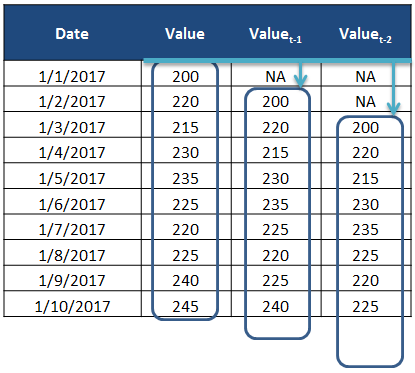 

We have the date as the index and value as the original value of the time series. Value <sub>t-1</sub> is a Time series with lag 1 and Value <sub>t-2</sub> is a time series with lag 2. So, Just as correlation shows how much two timeseries are similar, autocorrelation describes how similar the time series is with itself by measuring the correlation of the time series data with their lag. 

lags and autocorrelation are central to numerous forecasting models that incorporate autoregression, regressing a time series using previous values of itself. What we want is the original data series and their lag that did not correlate with each other as multicollinearity would messed up our model.

Autocorrelation plot is simply plot of the correlation of a series with its own lags, Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag. Autocorrelation would inlcude the base model, trend, cyclic and the seasonality. Partialcorellation plot would only present the base data without any effect from the trend, cyclic and, seasonality.  

The basis we use autocorellation plot to create stationary data is because we want to used method call differencing. Differencing is basically method that subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed. We could put the difference formula as shown below:

Y<sub>d</sub> = Y<sub>t</sub> - Y<sub>t-1</sub> - Y<sub>t-2</sub>...Y<sub>t-d</sub>


Lets see how is autocorellation plot work to determine the order of the differencing

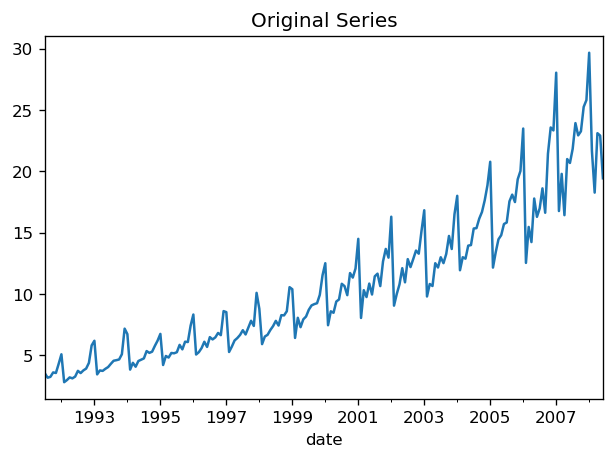

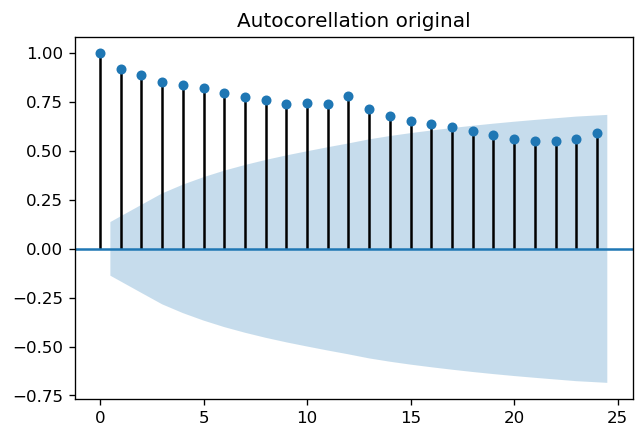

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})

# Original Series
ori = y.plot()
ori.set_title('Original Series')
plot_acf(y, title = 'Autocorellation original')

plt.show()

The autocorellation plot shown the correlation score with each number of the lags, where the blue area is the significance limit. 

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced. 

Just by looking at the autocorellation above, we could see that our data series need further differencing so lets try difference it by 1. Luckily, series already had .diff method to be used to automatically differecing our series. We need to also drop the NAN because it would affect the measurement. We could also use the Dickey-Fuller test to check the data stationary.


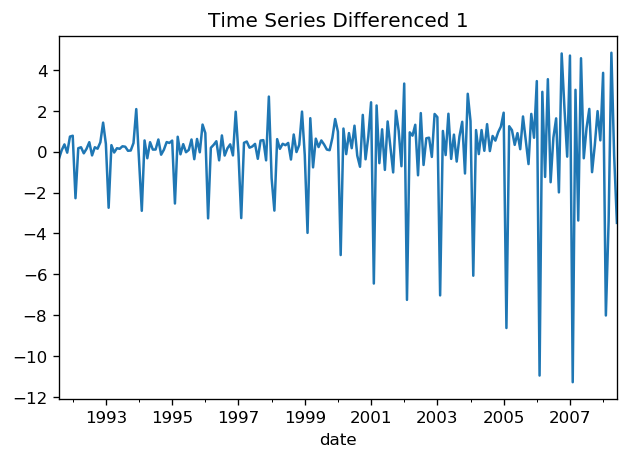

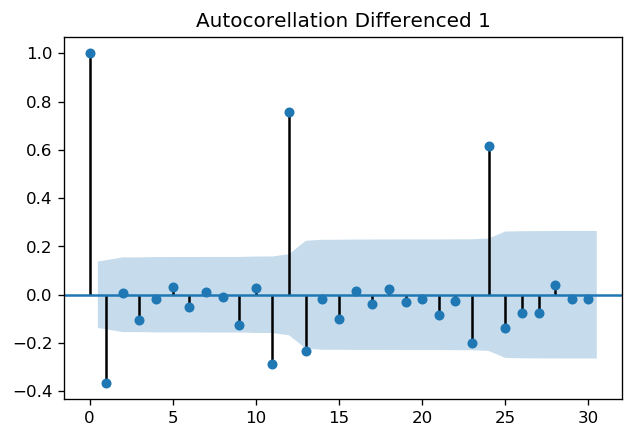

In [13]:
# 1st Differencing
diff1 = y.diff().dropna().plot()
diff1.set_title('Time Series Differenced 1')
plot_acf(y.diff().dropna(),lags =30,  title = 'Autocorellation Differenced 1')

plt.show()

In [14]:
result = adfuller(y.diff().dropna())
print('ADF Statistic:{}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic:-2.4951721474497273
p-value: 0.11665341686469083


Looking at the plot above and the test result, the differencing seems to be work although it seems further differencing is needed as the statistical result still shown it is non-stationary. Lets try one more time

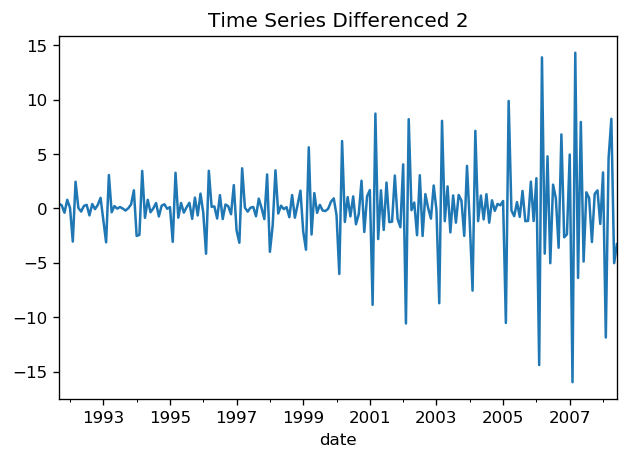

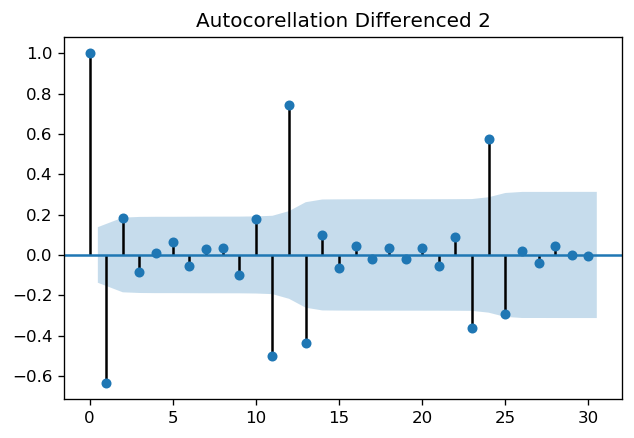

In [15]:
# 2nd Differencing
diff2 = y.diff().diff().dropna().plot()
diff2.set_title('Time Series Differenced 2')
plot_acf(y.diff().diff().dropna(),lags = 30, title = 'Autocorellation Differenced 2')

plt.show()

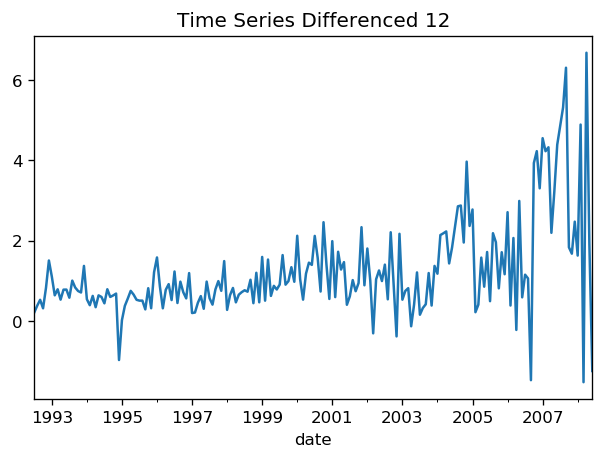

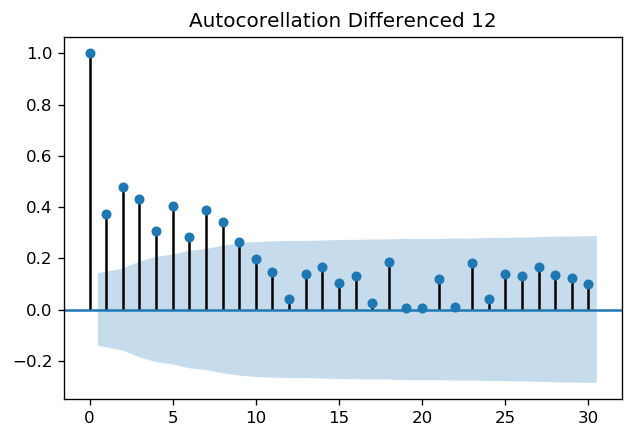

In [16]:
# 2nd Differencing
diff2 = y.diff(12).dropna().plot()
diff2.set_title('Time Series Differenced 12')
plot_acf(y.diff(12).dropna(),lags = 30, title = 'Autocorellation Differenced 12')

plt.show()

In [17]:
result = adfuller(y.diff().diff().dropna())
print('ADF Statistic:{}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic:-10.292304706517308
p-value: 3.543916358529571e-18


We can see from the result now that the P-value is less than our significant level, which means we could reject our null hypothesis now and regards the data as 'Stationary'. Although, by looking at the plot it seems there still a yearly seasonal effect and the correlation going fast to the negative zone which could means that the data is over-differencing. In this case, lets try to remove the seasonality from our series that have been difference by decompose our time series that have been differenced and use the seasonal value to remove the seasonality.

In [18]:
y_difference_2 = y.diff().diff().dropna()

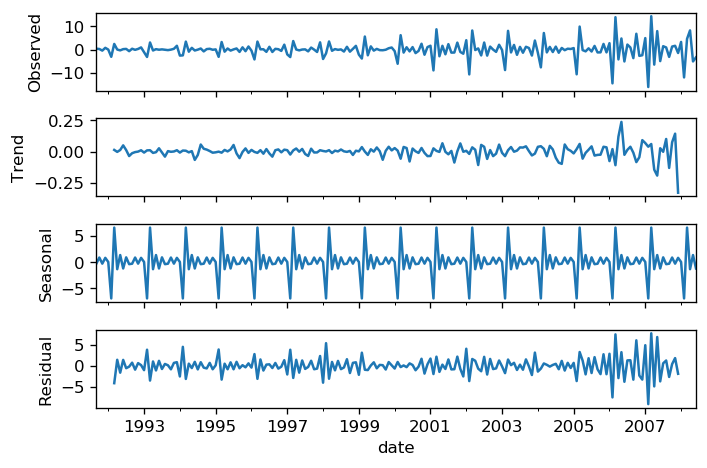

In [19]:
#We are using the Additive model because the plot look like it was following the addition model
decomposition_difference_2 = sm.tsa.seasonal_decompose(y_difference_2, model='additive') 
fig = decomposition_difference_2.plot()
plt.show()

In [20]:
y_deseason = y_difference_2/ decomposition_difference_2.seasonal

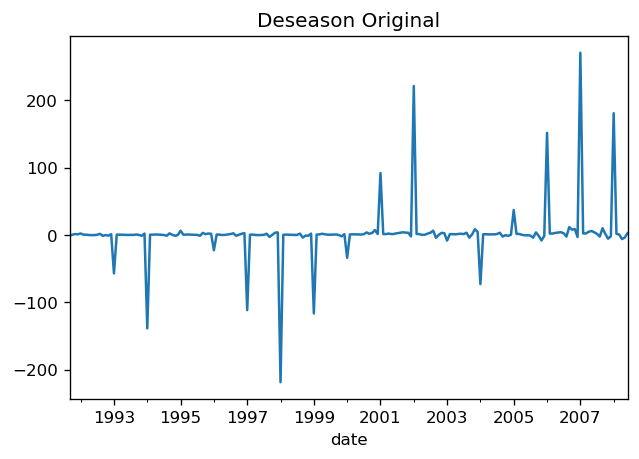

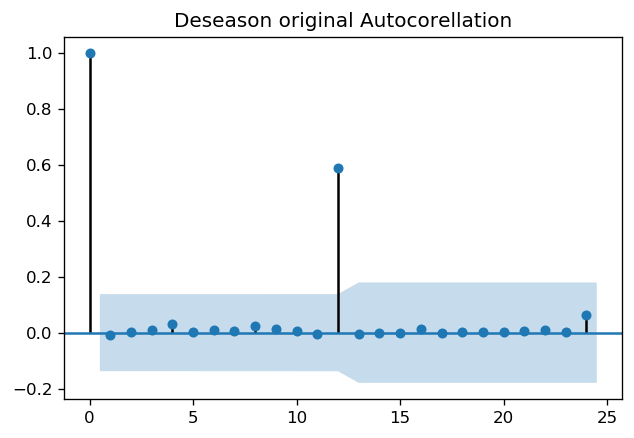

In [21]:
#Deseason original
ori_deseason = y_deseason.plot()
ori_deseason.set_title('Deseason Original')
plot_acf(y_deseason, title = 'Deseason original Autocorellation')

plt.show()

In [22]:
result = adfuller(y_deseason)
print('ADF Statistic:{}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic:-1.5655254707371287
p-value: 0.5008842717571488


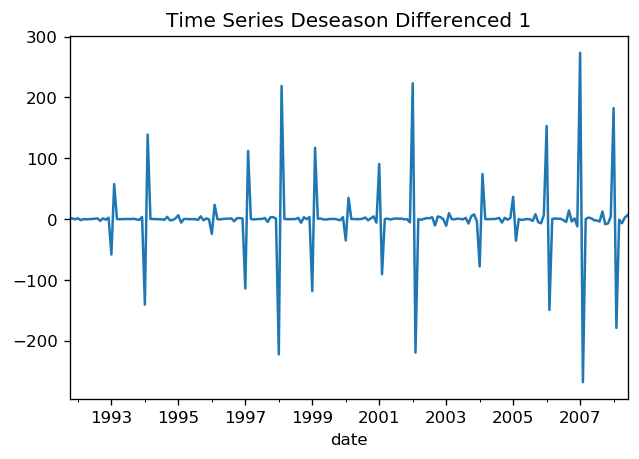

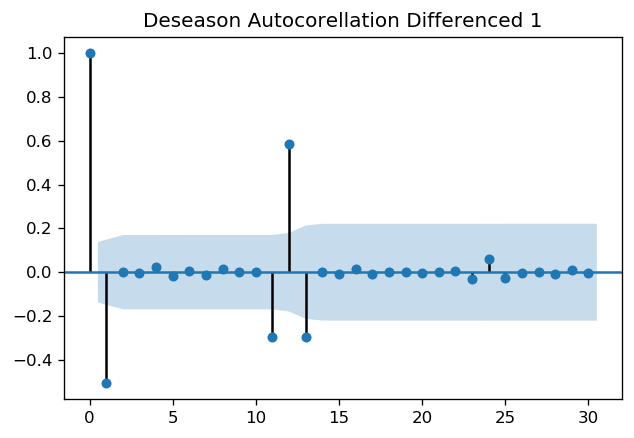

In [23]:
# 1st Differencing
diff1_deseason = y_deseason.diff().dropna().plot()
diff1_deseason.set_title('Time Series Deseason Differenced 1')
plot_acf(y_deseason.diff().dropna(),lags = 30, title = 'Deseason Autocorellation Differenced 1')

plt.show()

In [24]:
result = adfuller(y_deseason.diff().dropna())
print('ADF Statistic:{}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic:-13.810387974794962
p-value: 8.252198433360096e-26


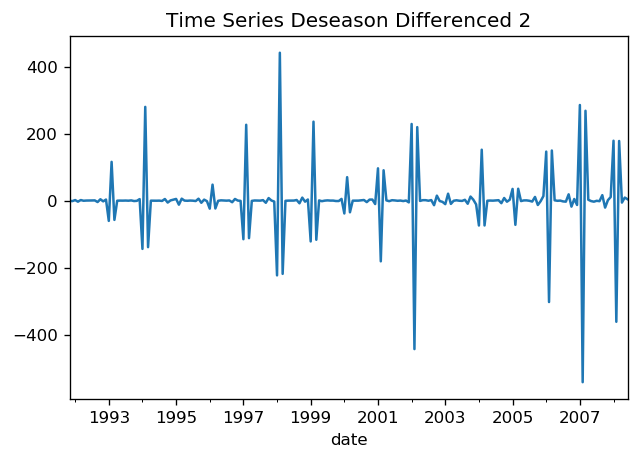

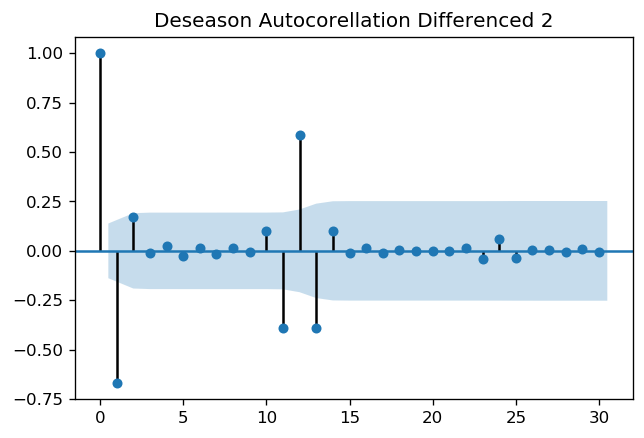

In [25]:
# 2nd Differencing
diff2_deseason = y_deseason.diff().diff().dropna().plot()
diff2_deseason.set_title('Time Series Deseason Differenced 2')
plot_acf(y_deseason.diff().diff().dropna(),lags = 30, title = 'Deseason Autocorellation Differenced 2')

plt.show()

In [26]:
result = adfuller(y_deseason.diff().diff().dropna())
print('ADF Statistic:{}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic:-8.725845031692133
p-value: 3.290442422499687e-14


Seems there is not much effect by deseasonalized our data. It might happen because our data have strong seasonality properties that become the signature of our data. For that, lets keep our data as it seems first and continue with our practice. Just be conservative first and keep the difference as 1

Now, before we proceed even further we need to understand the forecasting model that we would be use. In time series forecasting, ARIMA is a model that was used the most. For our practice, we would use ARIMA as our main forecasting model. 

<b>What is ARIMA model?</b> 

ARIMA is a class of model tha ‘explains’ a given time series based on its own past values; that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values. ARIMA need the data to be stationary and do not have any seasonality affecting the data.

An ARIMA model is characterized by 3 terms: 
p,q,d

p is the order of AR (Auto Regressive) term which refers to the number of lags of Y to be used as predictors.
q is the order of MA (Moving Average) term which refers to the number of lagged forecast errors that should go into the ARIMA Model.
d is the number of differencing required to make the data stationary.

It is called ARIMA because we use both AR model and MA model at the same time, and integrated with the differencing method. 

AR is a model where prediction Y<sub>t</sub> only depend from its own lags. The model formula could be seen below:
$$ Y_t = \alpha + \beta_1Y_{t-1} + \beta_2Y_{t-2}..+\beta_pY_{t-p} + \epsilon_1  $$

where, Y<sub>t-1</sub> is the lag 1 of the series, $\beta$<sub>1</sub> is the coefficient of lag 1 that the model estimates and $\alpha$ is the intercept term, also estimated by the model.

MA is a model that Y<sub>t</sub> is depend on the lagged forecast error. We could write the model as shown below:
$$ Y_t = \alpha + \epsilon_t + \phi_1\epsilon_{t-1} + \phi_2\epsilon_{t-2}+..+\phi_q\epsilon_{t-q} $$

MA error terms are the errors of the autoregressive models of the respective lags that we could acquired from the AR formula shown above.

ARIMA model is a model that was differenced at the very least once. If we modelled it into the equation, it could be shown as below:

$$ Y_t = \alpha + \beta_1Y_{t-1} + \beta_2Y_{t-2}..+\beta_pY_{t-p} + \epsilon_t + \phi_1\epsilon_{t-1} + \phi_2\epsilon_{t-2}+..+\phi_q\epsilon_{t-q}  $$

If we said it in the word, it would be like

Predicted Y<sub>t</sub> = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags).

The objective is to find this p, q, d term to be used for our ARIMA modelling. We already found our d term from the our analysis above, lets try to find the p and q.

How do we found p and q? we could use the ACF and PACF plot to help us found this parameter, lets start by try to find the p term by use the PACF plot

C:\Users\MSI\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


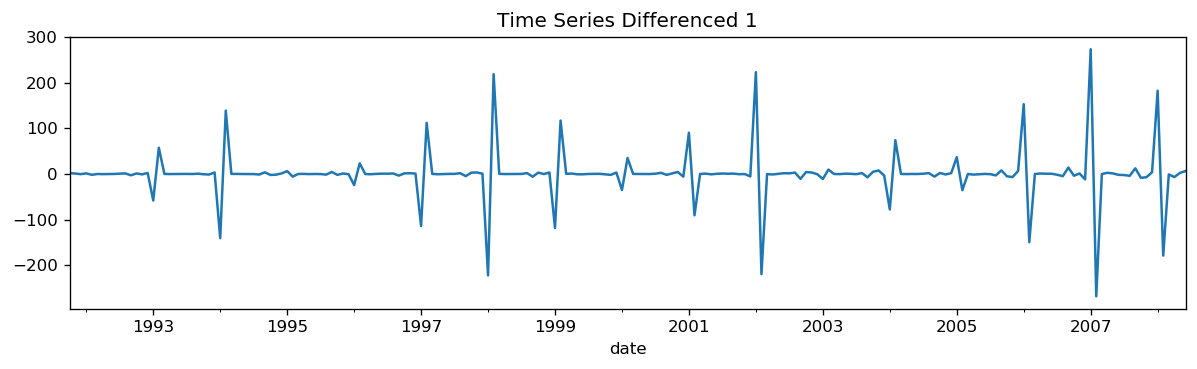

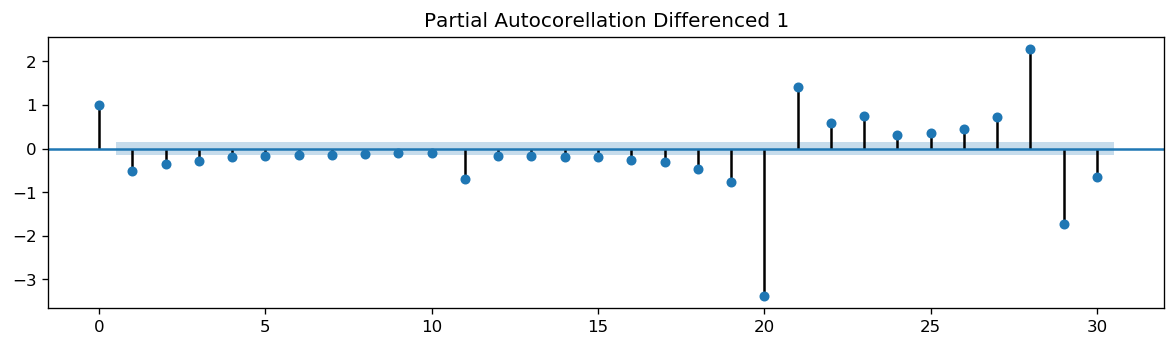

In [33]:
#PACF
diff1 = y_deseason.diff().dropna().plot()
diff1.set_title('Time Series Differenced 1')
plot_pacf(y_deseason.diff().dropna(), lags = 30, title = 'Partial Autocorellation Differenced 1')

plt.show()

To estimate the p term, we look at the first lag that cross the significant line. It seems lag 1 had cross the blue line, for that reason lets keep p term as 1

Now for q term, we could go back to our ACF plot with 1 differenced and using the same technique to find the q term. From the plot, lag 1 already cross the significant line so the q term is 1

It may so happen that the series is slightly under differenced, that differencing it one more time makes it slightly over-differenced.

How to handle this case?

If the series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, try adding an additional MA term.

## ARIMA model

time to build the ARIMA model for our forecasting. Let’s use the ARIMA() implementation in statsmodels package. The order of the term is always p,d,q so from our previous analysis we would use (1,1,1) as our ARIMA parameter 

In [28]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(y_deseason,order =(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               ARIMA Model Results                               
Dep. Variable:     D.sales_value_average   No. Observations:                  201
Model:                    ARIMA(1, 1, 1)   Log Likelihood               -1015.491
Method:                          css-mle   S.D. of innovations             37.332
Date:                   Sat, 05 Oct 2019   AIC                           2038.983
Time:                           22:23:23   BIC                           2052.196
Sample:                       10-01-1991   HQIC                          2044.329
                            - 06-01-2008                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.1255      0.043      2.906      0.004       0.041       0.210
ar.L1.D.sales_value_average    -0.0435      0.070     -0

From the summary, we could see that the ‘P>|z|’ columns in our AR and MA term are 0 which what we want as it means our constant are significant. Before continuing, lets plot our residual and examine the plot 

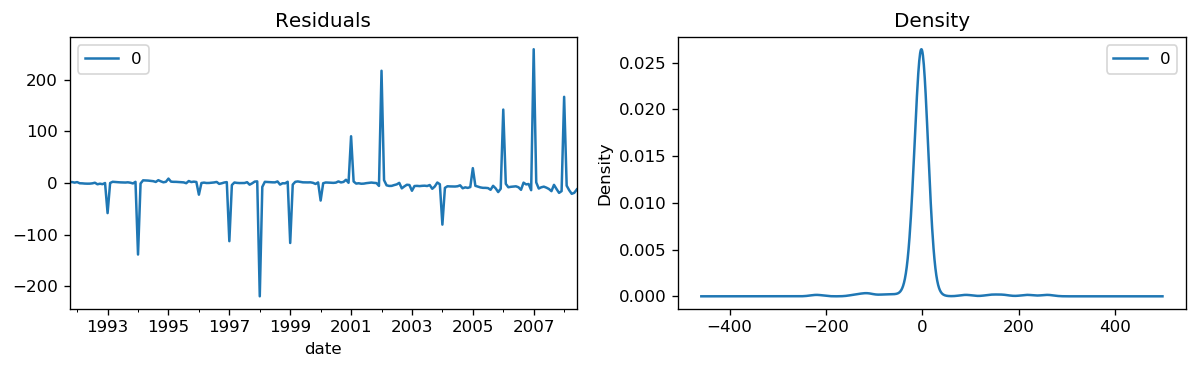

In [29]:
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual plot is not constant near zero, and the variance is not uniform (it increase thru the time). It seems our model seems hard to capture the underlying seasonality inside of the data. Just for our practice, lets try to work with this data a little bit more.

We could try the fit the data and use it to forecast our prediction and lets see what it would show

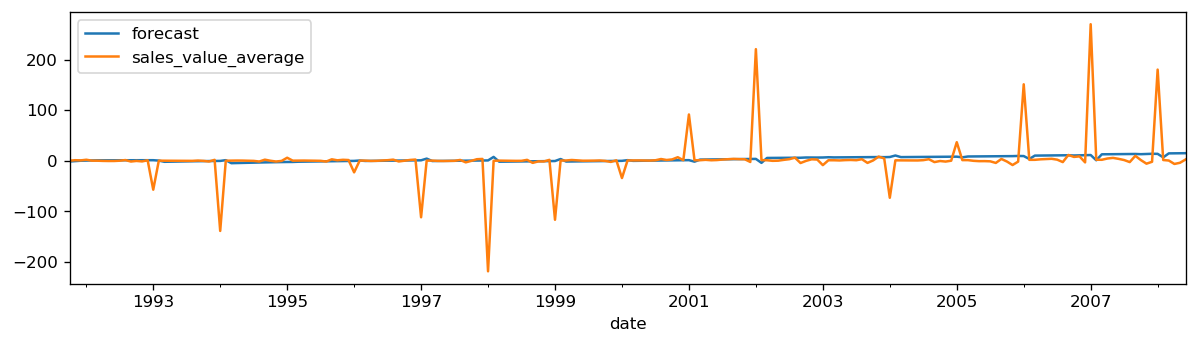

In [30]:
model_fit.plot_predict(dynamic=False)
plt.show()

## Out-of-time Cross Validation

The model seems to follow the actual data trend, although it could be because of overfitting. Now, we could try a method called Out-of-Time Cross Validation. This method take few steps back in time and forecast into the future to as many steps that was took back. Then it was compared to the forecast against the actuals. 

To create Out-of-time Cross Validation, we split the data into train and test datasaet. Often it was split into 1:4 ratio or as reasonable as it seems like depend on the data. The difference here, we are not random sampling the data like when we train another model. It is because the order of the time sequence should be intact.


Lets split the data now and try to predict using the Out-of-time Cross Validation

In [37]:
#Data split by close to 1:4 ratio

train = y_deseason[:152]
test = y_deseason[152:]

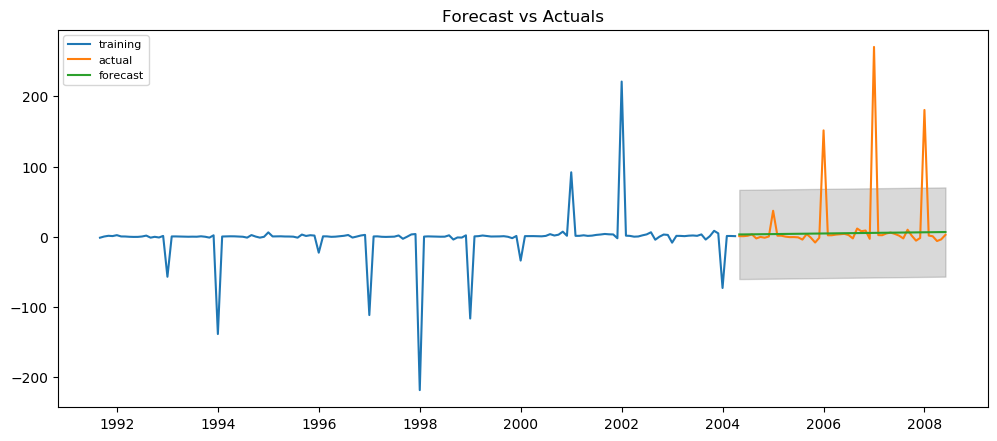

In [39]:
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast (resulted in forecast, standard error, and confidence interval)
fc, se, conf = fitted.forecast(50, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Just as we expected, the model seems cannot capture the actual data very well. In fact, it only give us the straight line. Although the prediction could capture the trend but the almost all of the actual data are not in the 95% significant area and our prediciton seems fall below the actual value. 

This is why, our model seems to be overfitted before and need additional training or even another model to capture the data seasonality.

Before we proceed to fix our model, lets practice try to measure the accuracy of our model. There are 3 metrics that often to be used in comparing forecast series; Mean Absolute Percentage Error (MAPE), Correlation between the actual and the Forecast (Correlation), and Min-Max Error (minmax)

Lets try to build our metrics

In [40]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
  
    return({'mape':mape,'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test)

{'mape': 3.1621396117472047,
 'corr': 0.12550980830785416,
 'minmax': 0.8934697121280697}

we get 3% MAPE, so it was about 97% accuracy to predict the next 50 forecast but as we see from the plot it seems not the case at all. That is why when we measuring accuracy, we combine it with the visualization power to actually see how our model really work

One more thing to practice, we could use a model called auto_arima with stepwise approach to actually find the optimal order parameter. Lets try to use this alghoritms

In [1]:
import pmdarima as pm

model = pm.auto_arima(y_deseason, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series (1 as monthly)
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())


KeyboardInterrupt: 

ARIMA auto model resulted in parameter order (2,1,0) as the best model parameter. We also need to check AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) to find the best parameter. The best model parameter would give the AIC and BIC score that was low.

Lets check the residual plot of our stepwise model

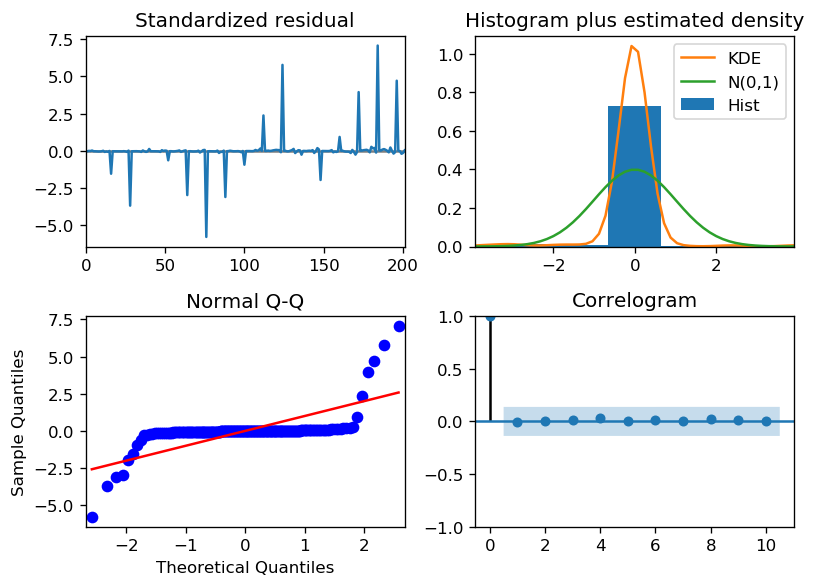

In [43]:
model.plot_diagnostics(figsize=(7,5))
plt.tight_layout()
plt.show()

How to intepret the residual plot?

Top left: The residual errors seem resulted in the not uniform variance, and the mean is not fluctuate around zero

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed. The dots seems not fall in the red line, it means that our distribution is little bit skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So we will need to look for more X’s (predictors) to the model.

## SARIMA (Seasonal ARIMA)

The problem with ARIMA is that this model does not support the effect of seasonality from the data. That is why, we need to use SARIMA model to have the seasonal difference. 

What is seasonal difference? Lets try to plot it out

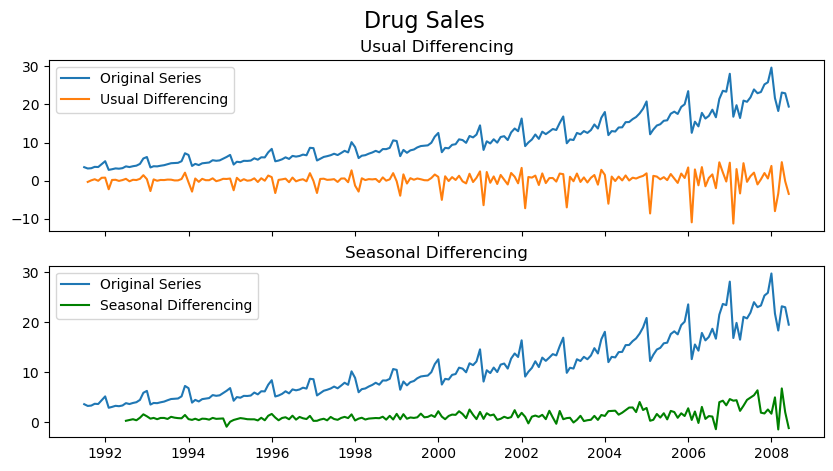

In [44]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(y, label='Original Series')
axes[0].plot(y.diff(), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

# Seasonal Differencing
axes[1].plot(y, label='Original Series')
axes[1].plot(y.diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Drug Sales', fontsize=16)
plt.show()

Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, we subtract the value from previous season.

From the plot, we could see the difference between the usual differencing and seasonal differencing. The usual differencing still keep the peak that signify the seasonal point. If we Compare it to the seasonal differencing, we could see that the data is smoothen up. This smoothen technique is much better than our previous attempt to deseasonalized our data.

In SARIMA, we still need to find our usual parameter p,d,q. We also have additional seasonal parameter P, D, Q, x that if we represented in the model would be as SARIMA(p,d,q)x(P,D,Q,x), where, P, D and Q are Seasonal AR, order of seasonal differencing and Seasonal MA terms respectively and 'x' is the frequency of the time series (12 for yearly, 4 for quarterly).

Here’s some practical advice on building SARIMA model:

As a general rule, set the model parameters such that D never exceeds one. And the total differencing ‘d + D’ never exceeds 2. Try to keep only either Seasonal AR or Seasonal MA terms if your model has seasonal components.

Lets try to build the model with auto_arima once more

In [45]:
model = pm.auto_arima(y, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # with Seasonality
                      start_P=0, 
                      start_Q = 0, 
                      D=1,            #Determine the Seasonal Difference as 1
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=624.061, BIC=630.576, Fit time=0.042 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=596.068, BIC=609.098, Fit time=0.279 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=611.475, BIC=624.505, Fit time=0.218 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=596.683, BIC=606.455, Fit time=0.078 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 12); AIC=591.868, BIC=608.156, Fit time=1.421 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 1, 12); AIC=593.603, BIC=613.148, Fit time=1.529 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 1, 0, 12); AIC=626.914, BIC=639.944, Fit time=0.978 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 1, 0, 12); AIC=547.829, BIC=567.374, Fit time=1.758 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(2, 1, 0, 12); AIC=529.414, BIC=552.217, Fit time=2.849 seconds
Fit ARIMA: order=(3, 0, 2) seasonal_order=(2, 

Using the auto_arima alghoritm, we get model parameter of SARIMAX(3, 0, 0)x(2, 1, 0, 12) that have the lowest AIC and BIC score. Lets try to plot the residual

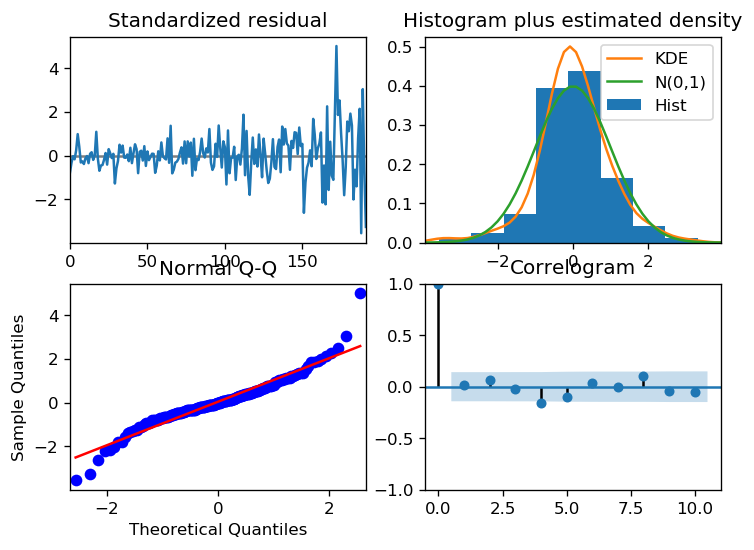

In [46]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

The residual seems to be much better than using only the ARIMA model. Lets try to have our prediction for the next 24 months

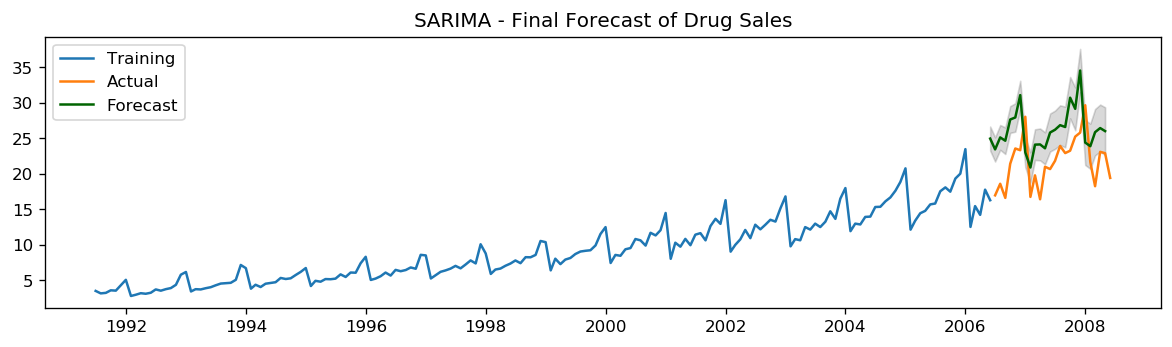

In [47]:
n_periods = 24
train = y[:180]
test = y[180:]

fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True) #Return the Confidence Interval
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train, label ='Training')
plt.plot(test, label = 'Actual')
plt.plot(fitted_series, color='darkgreen', label ='Forecast')
plt.legend()
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Drug Sales")
plt.show()

From the plot, it seems the prediction could capture the seasonality that was present and could follow the trend but still little bit over in the prediction compared to the actual value. Although, it still much better if it is compared to the ARIMA model. Of course, we could still fix this model even more. 

In [48]:
forecast_accuracy(fitted, test)

{'mape': 0.21728084462584543,
 'corr': 0.8409172745436392,
 'minmax': 0.17062667035542367}

We have 15 percent MAPE which equal to around 85% percent of the accuracy. If we compared to our previous ARIMA model, the accuracy seems even lower but just by look at the visualization its not even close. Time series data is not just rely on the number of the metrics but we also need to consider the visualization. 

## SARIMAX

There are 2 type of time series model; univariate and multivariate. Univariate use their own values to predict the future values, and multivariate present another external variable other than their own value called 'Exogenous Variable'. In ARIMA class model, there is SARIMAX model that could use this exogenous variable as additional variable to help us. Lets try to build our model

The only requirement to use an exogenous variable is we need to know the value of the variable during the forecast period as well.

In [49]:
#Decompose the time series data to get the seasonal data. Lets try to take 36 months back in the past as exogenous variable

# multiplicative seasonal component
result_mul = sm.tsa.seasonal_decompose(y[-36:],   # 36 months
                                model='multiplicative', 
                                extrapolate_trend='freq')

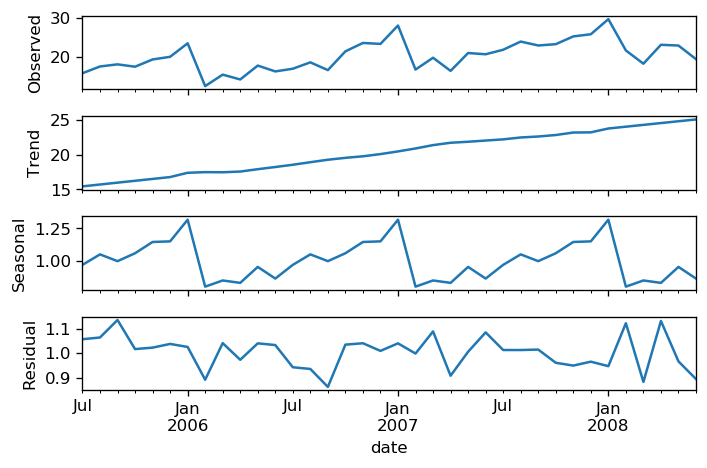

In [50]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
fig = result_mul.plot()
plt.show()

One of the advantages of decomposing the data is that we could acquire the seasonal value. From this result we would take what is called seasonal index. 

When we take the seasonal part from the series, this value is basically the value that cause the seasonality in the time series data. In our time series data, we have monthly frequency for the data which mean we have yearly cycle of 12 months. As our exogenous variable, we could take the latest 12 month seasonal data as a seasonal index to guide our SARIMAX model. But remember, this 12 month is the seasonal effect from 36 month data not an entire time series data that we had. We only want to force to introduce seasonal effect of 36 month data to our model.

Why only 12 months? Just by looking at the plot above that seasonality basically only looped around 12 months, and not change so much outside of those cycle. Which mean, we only need 12 month as our seasonal index. 

In [51]:
#We would use what we called seasonal index as our exogenous varibale. We take the latest 12 month.
seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

In [52]:
#lets merge it into one dataframe
y = pd.DataFrame(y)
y['month'] = y.index.month
df = pd.merge(y, seasonal_index, how='left', on='month')
df.columns = ['sales_value_average', 'month', 'seasonal_index']
df.index = y.index  # reassign the index.

In [53]:
df.head()

,sales_value_average,month,seasonal_index
date,,,
1991-07-01,3.526591,7,0.970490
1991-08-01,3.180891,8,1.050900
1991-09-01,3.252221,9,0.998881
1991-10-01,3.611003,10,1.059657
1991-11-01,3.565869,11,1.146141


Now we have the dataframe of our average sales value and our seasonal index. Lets build our model now with this data

In [54]:
sxmodel = pm.auto_arima(df[['sales_value_average']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=536.818, BIC=556.362, Fit time=0.897 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=626.061, BIC=635.834, Fit time=0.020 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=598.068, BIC=614.356, Fit time=0.405 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=613.475, BIC=629.762, Fit time=0.302 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=556.491, BIC=579.293, Fit time=1.583 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=561.407, BIC=577.695, Fit time=0.256 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=538.817, BIC=561.620, Fit time=2.463 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=539.733, BIC=565.793, Fit time=3.321 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=531.829, BIC=554.632, Fit time=0.989 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(3, 0, 0)x(1, 1, 2, 12)   Log Likelihood                -250.498
Date:                            Sat, 05 Oct 2019   AIC                            518.995
Time:                                    22:33:31   BIC                            548.313
Sample:                                         0   HQIC                           530.869
                                            - 204                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0205      0.027      0.748      0.455      -0.033       0.074
x1          6.638e-06   9.25e+04   7.18e-11      1.000   -1.81e+05    1.81e+05
ar.L1          0.0397      0.049      0.807      0.420      -0.057       0.136
ar.L2          0.4330      0.039     11.117      0.000       0.357       0.509
ar.L3          0.4347      0.056      7.765      0.000       0.325       0.544
ar.S.L12       0.8393      0.121      6.965      0.000       0.603       1.075
ma.S.L12      -1.6431      0.160    -10.276      0.000      -1.956      -1.330
ma.S.L24       0.8396      0.127      6.636      0.000       0.592       1.088
sigma2         0.6953      0.081      8.578      0.000       0.536       0.854
===================================================================================
Ljung-Box (Q):                       63.30   Jarque-Bera (JB):               118.33
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              13.06   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We now have our SARIMAX model, although the x1 coefficient is so small we could still try to forecast using our model. We would need our seasonal index data for this prediction. Lets try to forecast for the next 24 months

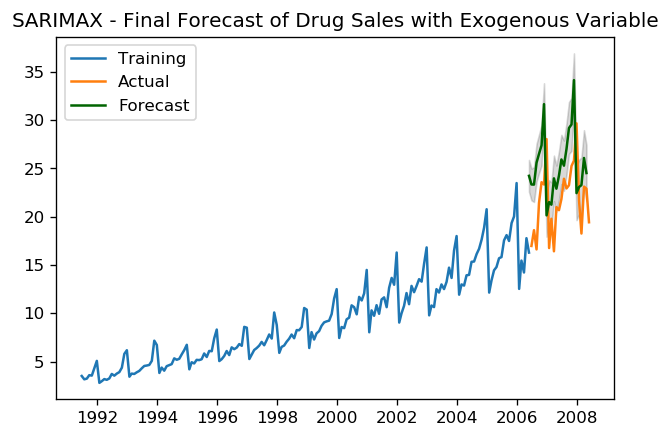

In [55]:
train = df[:180]
test = df[180:]

fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index['sales_value_average'], 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train['sales_value_average'], label ='Training')
plt.plot(test['sales_value_average'], label = 'Actual')
plt.plot(fitted_series, color='darkgreen', label ='Forecast')
plt.legend()
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX - Final Forecast of Drug Sales with Exogenous Variable")
plt.show()

In [56]:
forecast_accuracy(fitted, test['sales_value_average'])

{'mape': 0.17312998940950966,
 'corr': 0.8850501949047805,
 'minmax': 0.14176856795782988}

Our SARIMAX model certainly give slightly better prediction compared to the SARIMA model. Introducing exogenous variable could guide our model as we could seen from the plot. For learning process, this model does not give a bad result but of course we could still try other few things. 

Try to read from this link https://www.machinelearningplus.com/time-series/time-series-analysis-python/ for better understanding of what kind of things we could do with time series data. 